## Import Data

In [376]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import (train_test_split,
                                     RandomizedSearchCV,GridSearchCV)
from sklearn.preprocessing import (StandardScaler,
                                   MinMaxScaler,
                                   OneHotEncoder
                                  )

from sklearn.metrics import (
            confusion_matrix,
    roc_auc_score,recall_score
)

import phik


import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

RANDOM_STATE = 1111

In [209]:
messages = pd.read_csv('/Users/akmal/Documents/Masterskaya/STD_M2_purchase_in_90_days/filtered_data/apparel-messages.csv')
purchases = pd.read_csv('/Users/akmal/Documents/Masterskaya/STD_M2_purchase_in_90_days/filtered_data/apparel-purchases.csv')
target_binary = pd.read_csv('/Users/akmal/Documents/Masterskaya/STD_M2_purchase_in_90_days/filtered_data/apparel-target_binary.csv')

## Wrangle Data || Feature Creation

In [217]:
purchases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   client_id     202208 non-null  int64         
 1   quantity      202208 non-null  int64         
 2   price         202208 non-null  float64       
 3   category_ids  202208 non-null  object        
 4   date          202208 non-null  datetime64[ns]
 5   message_id    202208 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 9.3+ MB


In [211]:
purchases['date'] = pd.to_datetime(purchases['date'])

In [228]:
purchases_messages = purchases.merge(messages[messages['event']=='purchase'].drop_duplicates(subset='bulk_campaign_id'), how='left', on='message_id').sort_values('bulk_campaign_id')

In [302]:
purchases_messages = purchases.merge(messages[messages['event']=='purchase'].drop_duplicates(subset='bulk_campaign_id'), how='left', on='message_id').sort_values('bulk_campaign_id')
purchases_messages['channel'] = purchases_messages['channel'].fillna('organic')
purchases_messages['bulk_campaign_id'] = purchases_messages['bulk_campaign_id'].fillna('0')
purchases_messages = purchases_messages[['client_id_x', 'quantity', 'price', 'category_ids', 'date_x','message_id', 'bulk_campaign_id', 'channel']]
purchases_messages.columns = ['client_id', 'quantity', 'price', 'category_ids', 'date','message_id', 'bulk_campaign_id', 'channel']
purchases_messages

,client_id,quantity,price,category_ids,date,message_id,bulk_campaign_id,channel
86147,1515915625471518311,1,102.0,"['6060', '6058', '6065', '1848']",2023-02-25,1515915625471518311-563-60e55f1a5a7e6,563.0,email
86157,1515915625471518311,1,171.0,"['6060', '6058', '6061', '5504']",2023-02-25,1515915625471518311-563-60e55f1a5a7e6,563.0,email
86156,1515915625471518311,1,171.0,"['6060', '6058', '6061', '5504']",2023-02-25,1515915625471518311-563-60e55f1a5a7e6,563.0,email
86148,1515915625471518311,1,205.0,"['6060', '6058', '6065', '1848']",2023-02-25,1515915625471518311-563-60e55f1a5a7e6,563.0,email
86155,1515915625471518311,1,118.0,"['6060', '6058', '6065', '1848']",2023-02-25,1515915625471518311-563-60e55f1a5a7e6,563.0,email
...,...,...,...,...,...,...,...,...
202203,1515915626010261344,1,1499.0,"['2', '18', '212', '726']",2024-02-16,1515915626010261344-14648-65cdb6d56c4c8,0,organic
202204,1515915626010439406,1,99.0,"['4', '27', '233', '462']",2024-02-16,1515915625776605028-14662-65cf3abfe4f0d,0,organic
202205,1515915626010439406,1,99.0,"['4', '27', '233', '462']",2024-02-16,1515915625776605028-14662-65cf3abfe4f0d,0,organic
202206,1515915626010443527,1,1999.0,"['2', '18', '274', '446']",2024-02-16,1515915625766077627-14668-65cf5246bd490,0,organic


In [303]:
purchases[purchases.client_id== 1515915625853312319].sort_values('date')

,client_id,quantity,price,category_ids,date,message_id
41262,1515915625853312319,1,1819.0,"['2', '18', '258', '1562']",2022-10-20,1515915625478867789-7180-634d2f7a3f0bd
41337,1515915625853312319,1,2310.0,"['2', '18', '61', '660']",2022-10-23,1515915625478867789-7180-634d2f7a3f0bd
41338,1515915625853312319,1,3849.0,"['2', '18', '61', '660']",2022-10-23,1515915625478867789-7180-634d2f7a3f0bd
57416,1515915625853312319,1,666.0,"['2', '18', '258', '441']",2022-11-15,1515915625478867789-7845-6373358eaf65f
57417,1515915625853312319,1,666.0,"['2', '18', '258', '441']",2022-11-15,1515915625478867789-7845-6373358eaf65f
...,...,...,...,...,...,...
180618,1515915625853312319,1,199.0,"['6060', '6058', '6067', '5498']",2023-11-27,1515915625478867789-14182-6560562d0dd8a
181054,1515915625853312319,1,799.0,"['6060', '6058', '6065', '5501']",2023-12-01,1515915625478867789-14182-6560562d0dd8a
181055,1515915625853312319,1,533.0,"['6060', '6058', '6065', '5501']",2023-12-01,1515915625478867789-14182-6560562d0dd8a
181338,1515915625853312319,1,2999.0,"['4', '28', '104', '429']",2023-12-05,1515915625478867789-14225-6569b22d077eb


In [304]:
channel_cleints =  purchases_messages.groupby('client_id')['channel'].apply(lambda x: '-'.join(set(x)))
purchases_messages['bulk_campaign_id'] = purchases_messages['bulk_campaign_id'].astype('str')
campaign_clients = purchases_messages.groupby('client_id')['bulk_campaign_id'].apply(lambda x: '-'.join(set(x)))

In [305]:
purchases_agg = purchases.groupby(['client_id'], as_index=False).agg({'price':'mean','quantity':'sum','date':'max'})

In [306]:
# Getting latest purchase date, assuming this is date of export
purchases_agg['days_since_last_purchase'] = (purchases['date'].sort_values(ascending=False).reset_index(drop=True)[0] - purchases_agg['date']).dt.days 
purchases_agg

,client_id,price,quantity,date,days_since_last_purchase
0,1515915625468060902,999.000000,7,2022-05-27,630
1,1515915625468061003,2319.285714,7,2023-01-04,408
2,1515915625468061099,299.000000,1,2022-05-17,640
3,1515915625468061100,1049.000000,2,2024-02-10,6
4,1515915625468061170,1768.473684,19,2023-06-17,244
...,...,...,...,...,...
49844,1515915626010261344,1499.000000,6,2024-02-16,0
49845,1515915626010266132,909.000000,2,2024-02-14,2
49846,1515915626010439406,99.000000,2,2024-02-16,0
49847,1515915626010443527,1999.000000,1,2024-02-16,0


In [307]:
final_table = (purchases_agg.merge(channel_cleints.reset_index(), on='client_id', how='left')
                                 .merge(campaign_clients.reset_index(),on='client_id',how='left')
                                 .merge(target_binary,on='client_id',how='left')
)

final_table.head()

,client_id,price,quantity,date,days_since_last_purchase,channel,bulk_campaign_id,target
0,1515915625468060902,999.000000,7,2022-05-27,630,organic,0,0
1,1515915625468061003,2319.285714,7,2023-01-04,408,organic,0,1
2,1515915625468061099,299.000000,1,2022-05-17,640,organic,0,0
3,1515915625468061100,1049.000000,2,2024-02-10,6,organic,0,0
4,1515915625468061170,1768.473684,19,2023-06-17,244,organic,0,0


In [311]:
print("Duplicates count: ", final_table.duplicated().sum())
final_table.info()

Duplicates count:  0
<class 'pandas.core.frame.DataFrame'>
Int64Index: 49849 entries, 0 to 49848
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   client_id                 49849 non-null  int64         
 1   price                     49849 non-null  float64       
 2   quantity                  49849 non-null  int64         
 3   date                      49849 non-null  datetime64[ns]
 4   days_since_last_purchase  49849 non-null  int64         
 5   channel                   49849 non-null  object        
 6   bulk_campaign_id          49849 non-null  object        
 7   target                    49849 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(4), object(2)
memory usage: 3.4+ MB


## Multicollinearity

In [322]:
final_table['bulk_campaign_id'] = final_table['bulk_campaign_id'].astype('category')

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/phik/data_quality.py:59: UserWarning: The number of unique values of variable bulk_campaign_id is large: 1490. Are you sure this is not an interval variable? Analysis for pairs of variables including bulk_campaign_id can be slow.
  warnings.warn(


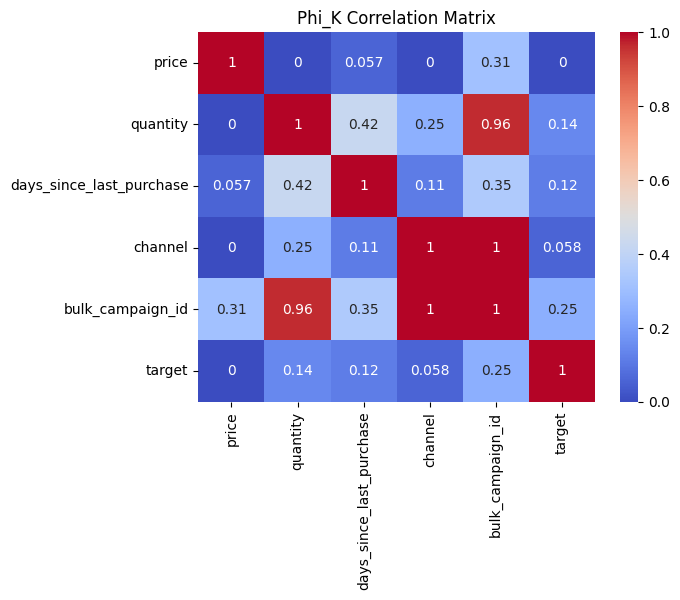

In [323]:
corr_matrix = final_table[['price','quantity','days_since_last_purchase', 'channel', 'bulk_campaign_id', 'target']].phik_matrix(interval_cols=['days_since_last_purchase', 'price'])
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Phi_K Correlation Matrix')
plt.show()

## Pipeline

In [326]:
final_table

,client_id,price,quantity,date,days_since_last_purchase,channel,bulk_campaign_id,target
0,1515915625468060902,999.000000,7,2022-05-27,630,organic,0,0
1,1515915625468061003,2319.285714,7,2023-01-04,408,organic,0,1
2,1515915625468061099,299.000000,1,2022-05-17,640,organic,0,0
3,1515915625468061100,1049.000000,2,2024-02-10,6,organic,0,0
4,1515915625468061170,1768.473684,19,2023-06-17,244,organic,0,0
...,...,...,...,...,...,...,...,...
49844,1515915626010261344,1499.000000,6,2024-02-16,0,organic,0,0
49845,1515915626010266132,909.000000,2,2024-02-14,2,organic,0,0
49846,1515915626010439406,99.000000,2,2024-02-16,0,organic,0,0
49847,1515915626010443527,1999.000000,1,2024-02-16,0,organic,0,0


In [338]:
X_train, X_test, y_train, y_test = train_test_split(final_table.drop(['client_id','date','target'], axis=1)
                                                    , final_table['target']
                                                    , random_state=RANDOM_STATE
                                                    , test_size=0.25
                                                   , stratify=final_table['target'])

In [339]:
num_cols = ['price','days_since_last_purchase','quantity']
cat_cols = ['channel','bulk_campaign_id']

In [344]:
ohe_pipeline = Pipeline(
    [
     ('simpliImputer_ohe', SimpleImputer(strategy='most_frequent', missing_values=np.nan)),
     ('ohe', OneHotEncoder(drop='first',handle_unknown='ignore',sparse_output=False))
    ]
)


num_pipeline = Pipeline(
    [
     ('simpliImputer_num', SimpleImputer(strategy='median', missing_values=np.nan)),
     ('num', StandardScaler())
    ]
)


data_preprocessor = ColumnTransformer(
[('ohe', ohe_pipeline, cat_cols),
 ('num',num_pipeline, num_cols)
], remainder='passthrough')

In [359]:
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
)

param_grid = [
    #DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2,5),
        'models__max_features': range(2,5),
        'preprocessor__num': [SimpleImputer(strategy='median', missing_values=np.nan),StandardScaler(), MinMaxScaler(),'passthrough']
    },

    #KNeighborsClassifier()
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2,5),
        'preprocessor__num': [SimpleImputer(strategy='median', missing_values=np.nan),StandardScaler(), MinMaxScaler(), 'passthrough']
    },

    #LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE,
            solver='liblinear',
            penalty='l1'
        )],
        'models__C': range(1,5),
        'preprocessor__num': [SimpleImputer(strategy='median', missing_values=np.nan),StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

In [363]:
grid = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
grid.fit(X_train,y_train)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown cat

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpliImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['channel',
                                                                                'bulk_campaign_id']),
                                                                              ('num',
                                                                               Pipeline(steps=[('simp...
                                         'models__n_neighbors': range(2, 5),
                                         'preprocessor__num': [SimpleImputer(strategy='median'),
                                                               StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [LogisticRegression(penalty='l1',
                                                                       random_state=1111,
                                                                       solver='liblinear')],
                                         'models__C': range(1, 5),
                                         'preprocessor__num': [SimpleImputer(strategy='median'),
                                                               StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=1111, scoring='roc_auc')

In [387]:
y_pred_proba = grid.best_estimator_.predict_proba(X_test)[:,1]
roc_auc_score(y_test, y_pred_proba)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


0.6807608265837629